<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/tf_quantum_svgCircuit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_quantum


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 4.7 MB/s 
     |████████████████████████████████| 576 kB 32.2 MB/s 
     |████████████████████████████████| 6.1 MB 9.0 MB/s 
     |████████████████████████████████| 100 kB 2.7 MB/s 
     |████████████████████████████████| 90 kB 5.5 MB/s 
     |████████████████████████████████| 90 kB 9.4 MB/s 
     |████████████████████████████████| 1.6 MB 50.7 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 641 kB 45.8 MB/s 
     |████████████████████████████████| 541 kB 26.1 MB/s 
     |████████████████████████████████| 541 kB 46.9 MB/s 
     |████████████████████████████████| 437 kB 46.7 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 93 kB 1.0 MB/s 
     |████████████████████████████████| 93 kB

In [2]:
import cirq
import sympy
import tensorflow
import numpy

%matplotlib inline
import matplotlib.pyplot

from cirq.contrib.svg import SVGCircuit

import tensorflow_quantum

In [3]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


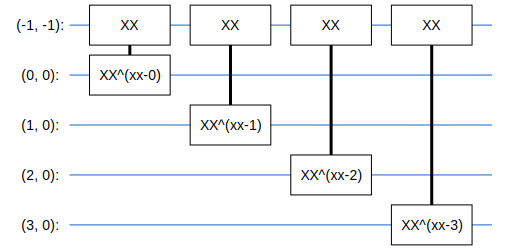

In [4]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [5]:
def create_quantum_model():

    # cirq
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")
    builder.add_layer(circuit, cirq.CZ, "cz1")    

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [6]:
model_circuit, model_readout = create_quantum_model()

In [7]:
# Build the Keras model.
model = tensorflow.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tensorflow.keras.layers.Input(shape=(), dtype=tensorflow.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tensorflow_quantum.layers.PQC(model_circuit, model_readout),
])

In [8]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., numpy.newaxis]/255.0, x_test[..., numpy.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11501568/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [9]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [10]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


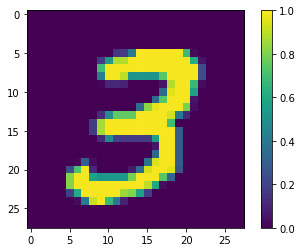

In [11]:
print(y_train[0])

matplotlib.pyplot.imshow(x_train[0, :, :, 0])
matplotlib.pyplot.colorbar()

In [12]:
x_train_small = tensorflow.image.resize(x_train, (4,4)).numpy()
x_test_small = tensorflow.image.resize(x_test, (4,4)).numpy()

In [13]:
x_train_nocon, y_train_nocon = x_train_small[:100], y_train[:100]

In [14]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [15]:
THRESHOLD = 0.5

x_train_bin = numpy.array(x_train_nocon > THRESHOLD, dtype=numpy.float32)
x_test_bin = numpy.array(x_test_small > THRESHOLD, dtype=numpy.float32)

In [16]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = numpy.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

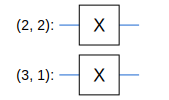

In [17]:
SVGCircuit(x_train_circ[0])

In [18]:
bin_img = x_train_bin[0,:,:,0]
indices = numpy.array(numpy.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

In [19]:
x_train_tfcirc = tensorflow_quantum.convert_to_tensor(x_train_circ)
x_test_tfcirc = tensorflow_quantum.convert_to_tensor(x_test_circ)

In [20]:
def hinge_accuracy(y_true, y_pred):
    y_true = tensorflow.squeeze(y_true) > 0.0
    y_pred = tensorflow.squeeze(y_pred) > 0.0
    result = tensorflow.cast(y_true == y_pred, tensorflow.float32)

    return tensorflow.reduce_mean(result)

In [21]:
model.compile(
    loss=tensorflow.keras.losses.Hinge(),
    optimizer=tensorflow.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [22]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 48        
                                                                 
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [24]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [25]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
4/4 [==============================] - 71s 21s/step - loss: 1.0179 - hinge_accuracy: 0.2344 - val_loss: 1.0087 - val_hinge_accuracy: 0.3090
Epoch 2/3
4/4 [==============================] - 63s 20s/step - loss: 1.0138 - hinge_accuracy: 0.2344 - val_loss: 1.0070 - val_hinge_accuracy: 0.3916
Epoch 3/3
62/62 [==============================] - 49s 787ms/step - loss: 1.0054 - hinge_accuracy: 0.4738


In [29]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


data = {
    "id": [1, 2, 3, 4, 5,],
    "fruit": ["Apple", "Apple", "Peach", "Banana"],
}
df = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})

pipe = Pipeline(
    steps=[
        ("simple_one_hot_encode", FunctionTransformer(pd.get_dummies))
    ]
)
transformed_df = pipe.fit_transform(df)

print(transformed_df)

In [30]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


data = {
    "id": [1, 2, 3, 4, 5,],
    "fruit": ["Apple", "Apple", "Peach", "Banana"],
}
df = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})

pipe = Pipeline(
    steps=[
        ("simple_one_hot_encode", FunctionTransformer(pd.get_dummies))
    ]
)
transformed_df = pipe.fit_transform(df)

print(transformed_df)

   id  fruit_Apple  fruit_Banana  fruit_Peach
0   1            1             0            0
1   2            1             0            0
2   3            0             0            1
3   4            0             1            0
4   5            0             0            0


In [159]:
from sklearn.datasets import fetch_california_housing

# X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X, y = (x_test_tfcirc, y_test)
# X, y = (x_train_tfcirc_sub, y_test_hinge)

In [149]:
# X.head()

print(type(y))
# y.head()



# type(y)

<class 'numpy.ndarray'>


In [109]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# y = y.reshape(1, -1)
# X = X.reshape(-1, 1) 

In [156]:
print(y)
print(type(y))
print((y.size))
print((y.shape))

[-1.  1. -1. ... -1.  1. -1.]
<class 'numpy.ndarray'>
1968
(1968,)


In [160]:
print(X)
print(type(X))
print((X.size))
print((X.shape))
c_X = X.tolist()
print(c_X)
print(type(c_X))
print((c_X.size))
print((c_X.shape))

tf.Tensor(
[b'\n\x0e\n\x0ctfq_gate_set\x12\x8f\x01\x08\x01\x12\x8a\x01\n\x87\x01\n\x04\n\x02XP\x12\x16\n\x0econtrol_qubits\x12\x04\n\x02\x1a\x00\x12\x16\n\x0econtrol_values\x12\x04\n\x02\x1a\x00\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x031_2'
 b'\n\x0e\n\x0ctfq_gate_set\x12\x8f\x01\x08\x01\x12\x8a\x01\n\x87\x01\n\x04\n\x02XP\x12\x16\n\x0econtrol_values\x12\x04\n\x02\x1a\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x16\n\x0econtrol_qubits\x12\x04\n\x02\x1a\x00\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x032_1'
 b'\n\x0e\n\x0ctfq_gate_set\x12\x99\x02\x08\x01\x12\x94\x02\n\x87\x01\n\x04\n\x02XP\x12\x16\n\x0econtrol_values\x12\x04\n\x02\x1a\x00\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\

AttributeError: ignored

In [145]:
print(type(X))
X = X.tolist()

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [146]:
X

[b'\n\x0e\n\x0ctfq_gate_set\x12\x99\x02\x08\x01\x12\x94\x02\n\x87\x01\n\x04\n\x02XP\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x16\n\x0econtrol_qubits\x12\x04\n\x02\x1a\x00\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x12\x16\n\x0econtrol_values\x12\x04\n\x02\x1a\x00\x1a\x05\x12\x032_2\n\x87\x01\n\x04\n\x02XP\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x16\n\x0econtrol_qubits\x12\x04\n\x02\x1a\x00\x12\x16\n\x0econtrol_values\x12\x04\n\x02\x1a\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x033_1',
 b'\n\x0e\n\x0ctfq_gate_set\x12\x99\x02\x08\x01\x12\x94\x02\n\x87\x01\n\x04\n\x02XP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x16\n\x0econtrol_qubits\x12\x04\n\x02\x1a\x00\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x12\x16\n\x0econtrol_values\x12\x04\n\x02\x1a\x00\x12\x13\n\x08expon

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold

class AwesomeEstimator(RegressorMixin, BaseEstimator):
    def __init__(self):
        pass

    def __get_pipeline(self):
        scaler = MinMaxScaler()
        
        regressor = RandomForestRegressor(**{
            'random_state': 37
        })

        steps=[
            ('scaler', scaler),
            ('regressor', regressor)]

        pipeline = Pipeline(steps=steps)
        return pipeline

    def __get_model(self, feature_range, n_estimators):
        model = GridSearchCV(**{
            'estimator': self.__get_pipeline(),
            'cv': 5,
            'param_grid': {
                'scaler__feature_range': feature_range,
                'regressor__n_estimators': n_estimators
            },
            'scoring': 'neg_mean_absolute_error',
            'verbose': 5,
            'refit': 'neg_mean_absolute_error',
            'error_score': np.NaN,
            'n_jobs': -1
        })
        return model


    def fit(self, X, y, feature_range=[(0, 1)], n_estimators=[100]):
        if y is None:
            raise ValueError('requires y to be passed, but the target y is None')

        X, y = check_X_y(X, y)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]

        self.model_ = self.__get_model(feature_range, n_estimators)
        self.model_.fit(X, y)

        return self

    def predict(self, X):
        check_is_fitted(self, ['is_fitted_', 'model_'])
        return self.model_.predict(X)

check_estimator(AwesomeEstimator())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: ignored

In [140]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

estimator = AwesomeEstimator()
estimator.fit(X, y)
# estimator.fit(X, y.reshape(-1, 1))
# estimator.fit(X, y.reshape(1, -1))
# estimator.fit(X.reshape(-1, 1), y)
# estimator.fit(X.reshape(1, -1), y)
y_pred = estimator.predict(X)

mae = mean_absolute_error(y, y_pred)
mse = np.sqrt(mean_squared_error(y, y_pred))
rsq = r2_score(y, y_pred)

print(f'mae {mae:.5f}, rmse {mse:.5f}, rsq {rsq:.5f}')

ValueError: ignored